# Desafio de Regressão Linear - Quinto Andar / Tera

In [1]:
# Importando as bibliotecas necessárias:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import List, Tuple

# Bibliotecas de estatísticas
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

# Bibliotecas de modelagem
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance
from sklearn.inspection import permutation_importance

# Codificadores categóricos
!pip install --upgrade category_encoders
from category_encoders.target_encoder import TargetEncoder
from matplotlib.dates import DateFormatter

sns.set(font_scale=1.2, style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

### Criando funções que serão utilizadas durante o projeto

In [2]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Configurando a figura do matplotlib
  fig, ax = plt.subplots(figsize=size)

  # Gerando um mapa de cores divergente personalizado
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Gerando uma máscara para o triângulo superior
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Desenhando o mapa de calor com a máscara e a proporção correta
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Função para calcular o VIF
def calc_vif(df):
  """ 
    Fatores de inflação variáveis
     O VIF determina a força da correlação entre as variáveis independentes. É previsto tomando uma variável e regredindo-a em relação a todas as outras variáveis.
    Referencia: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculando o VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

#Função para criar Datasets de treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Divide o dataframe em conjuntos de treinamento, teste e validação"""

    # A primeira divisão de treino/teste
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # A segunda divisão de treino/teste
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

In [3]:
# Importando os dados
df = pd.read_csv("base.csv", encoding="UTF-8", sep=",")
df.drop('Id', axis=1, inplace=True)

### EDA  / Pré-processamento, limpeza dos dados, construção de features

In [4]:
df.head()

,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,Beco,FormaProp,PlanoProp,Servicos,ConfigLote,...,AreaPiscina,QualidadePiscina,QualidadeCerca,Outros,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.shape

(1460, 80)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ClasseImovel          1460 non-null   int64  
 1   ClasseZona            1460 non-null   object 
 2   Fachada               1201 non-null   float64
 3   TamanhoLote           1460 non-null   int64  
 4   Rua                   1460 non-null   object 
 5   Beco                  91 non-null     object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [7]:
# Transformar variáveis object em categóricas
# Criando a função para atender aos requisitos acima
def mudar_tipo(x):

    if x.dtype == "object":
        return x.astype("category")
    return x

df= df.apply(lambda x: mudar_tipo(x))

In [8]:
#As variáveis abaixo são variáveis Categóricas e não discretas
df.ClasseImovel = df.ClasseImovel.astype('category')
df.Condicao = df.Condicao.astype('category')

In [9]:
# Conferindo se deu certo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ClasseImovel          1460 non-null   category
 1   ClasseZona            1460 non-null   category
 2   Fachada               1201 non-null   float64 
 3   TamanhoLote           1460 non-null   int64   
 4   Rua                   1460 non-null   category
 5   Beco                  91 non-null     category
 6   FormaProp             1460 non-null   category
 7   PlanoProp             1460 non-null   category
 8   Servicos              1460 non-null   category
 9   ConfigLote            1460 non-null   category
 10  InclinacaoLote        1460 non-null   category
 11  Bairro                1460 non-null   category
 12  Estrada1              1460 non-null   category
 13  Estrada2              1460 non-null   category
 14  TipoHabitacao         1460 non-null   category
 15  Esti

In [10]:
#verificando os nulos nas colunas
df.isnull().sum().head(21)

ClasseImovel          0
ClasseZona            0
Fachada             259
TamanhoLote           0
Rua                   0
Beco               1369
FormaProp             0
PlanoProp             0
Servicos              0
ConfigLote            0
InclinacaoLote        0
Bairro                0
Estrada1              0
Estrada2              0
TipoHabitacao         0
EstiloHabitacao       0
Qualidade             0
Condicao              0
AnoConstrucao         0
AnoReforma            0
TipoTelhado           0
dtype: int64

In [11]:
df.isnull().sum().tail(60)

TipoTelhado                0
MaterialTelhado            0
Exterior1                  0
Exterior2                  0
TipoAlvenaria              8
AreaAlvenaria              8
QualidadeCobertura         0
CondicaoExterna            0
TipoFundacao               0
AlturaPorao               37
CondicaoPorao             37
ParedePorao               38
TipoAcabPorao1            37
AreaAcabPorao1             0
TipoAcabPorao2            38
AreaAcabPorao2             0
AreaInacabPorao            0
AreaPorao                  0
Aquecimento                0
QualidadeAquecimento       0
ArCentral                  0
InstalacaoEletrica         1
AreaTerreo                 0
Area2Andar                 0
BaixaQualiAreaAcab         0
AreaConstruida             0
BanheiroPorao              0
LavaboPorao                0
Banheiro                   0
Lavabo                     0
BedroomAbvGr               0
KitchenAbvGr               0
QualidadeCozinha           0
TotalQuartos               0
Funcionalidade

In [12]:
df.isnull().mean().head(21).round(4)*100

ClasseImovel        0.00
ClasseZona          0.00
Fachada            17.74
TamanhoLote         0.00
Rua                 0.00
Beco               93.77
FormaProp           0.00
PlanoProp           0.00
Servicos            0.00
ConfigLote          0.00
InclinacaoLote      0.00
Bairro              0.00
Estrada1            0.00
Estrada2            0.00
TipoHabitacao       0.00
EstiloHabitacao     0.00
Qualidade           0.00
Condicao            0.00
AnoConstrucao       0.00
AnoReforma          0.00
TipoTelhado         0.00
dtype: float64

In [13]:
df.isnull().mean().tail(60).round(4)*100

TipoTelhado              0.00
MaterialTelhado          0.00
Exterior1                0.00
Exterior2                0.00
TipoAlvenaria            0.55
AreaAlvenaria            0.55
QualidadeCobertura       0.00
CondicaoExterna          0.00
TipoFundacao             0.00
AlturaPorao              2.53
CondicaoPorao            2.53
ParedePorao              2.60
TipoAcabPorao1           2.53
AreaAcabPorao1           0.00
TipoAcabPorao2           2.60
AreaAcabPorao2           0.00
AreaInacabPorao          0.00
AreaPorao                0.00
Aquecimento              0.00
QualidadeAquecimento     0.00
ArCentral                0.00
InstalacaoEletrica       0.07
AreaTerreo               0.00
Area2Andar               0.00
BaixaQualiAreaAcab       0.00
AreaConstruida           0.00
BanheiroPorao            0.00
LavaboPorao              0.00
Banheiro                 0.00
Lavabo                   0.00
BedroomAbvGr             0.00
KitchenAbvGr             0.00
QualidadeCozinha         0.00
TotalQuart

In [14]:
# Dropando colunas com grande quantidade de nulos
# Beco               93.77 - REMOVER
# QualidadePiscina   99.52 - REMOVER
# QualidadeCerca     80.75 - REMOVER
# Outros             96.30 - REMOVER
df = df.drop(columns=['Beco', 'QualidadePiscina', 'QualidadeCerca', 'Outros'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ClasseImovel          1460 non-null   category
 1   ClasseZona            1460 non-null   category
 2   Fachada               1201 non-null   float64 
 3   TamanhoLote           1460 non-null   int64   
 4   Rua                   1460 non-null   category
 5   FormaProp             1460 non-null   category
 6   PlanoProp             1460 non-null   category
 7   Servicos              1460 non-null   category
 8   ConfigLote            1460 non-null   category
 9   InclinacaoLote        1460 non-null   category
 10  Bairro                1460 non-null   category
 11  Estrada1              1460 non-null   category
 12  Estrada2              1460 non-null   category
 13  TipoHabitacao         1460 non-null   category
 14  EstiloHabitacao       1460 non-null   category
 15  Qual

In [15]:
# Separando as variáveis:
# Variável de interesse
target = 'PrecoVenda'
print('target:', target)

# Variáveis numéricas
vars_num = df.select_dtypes(include=['int', 'float']).columns.tolist()
vars_num.remove('PrecoVenda')
print(f'\nVariáveis numéricas({len(vars_num)}): {vars_num}')

# Variáveis categóricas
vars_cat = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
print(f'\nVariáveis Categóricas({len(vars_cat)}): {vars_cat}')


target: PrecoVenda

Variáveis numéricas(34): ['Fachada', 'TamanhoLote', 'Qualidade', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda']

Variáveis Categóricas(41): ['ClasseImovel', 'ClasseZona', 'Rua', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'Condicao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoA

In [16]:
# Medidas de resumo das variáveis quantitativas
df.describe(percentiles = [.25, .50, .75, .95, .99], include=['int64', 'float64']).round(2)

,Fachada,TamanhoLote,Qualidade,AnoConstrucao,AnoReforma,AreaAlvenaria,AreaAcabPorao1,AreaAcabPorao2,AreaInacabPorao,AreaPorao,...,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,PrecoVenda
count,1201.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,...,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,70.05,10516.83,6.10,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,...,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,24.28,9981.26,1.38,30.20,20.65,181.07,456.10,161.32,441.87,438.71,...,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,21.00,1300.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,59.00,7553.50,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,69.00,9478.50,6.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,...,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,80.00,11601.50,7.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,...,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
95%,107.00,17401.15,8.00,2007.00,2007.00,456.00,1274.00,396.20,1468.00,1753.00,...,335.00,175.05,180.15,0.00,160.00,0.00,0.00,11.00,2010.00,326100.00
99%,141.00,37567.64,10.00,2009.00,2009.00,791.92,1572.41,830.38,1797.05,2155.05,...,505.46,285.82,261.05,168.00,268.05,0.00,700.00,12.00,2010.00,442567.01
max,313.00,215245.00,10.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,...,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


<AxesSubplot:xlabel='LogPrecoVenda', ylabel='Count'>

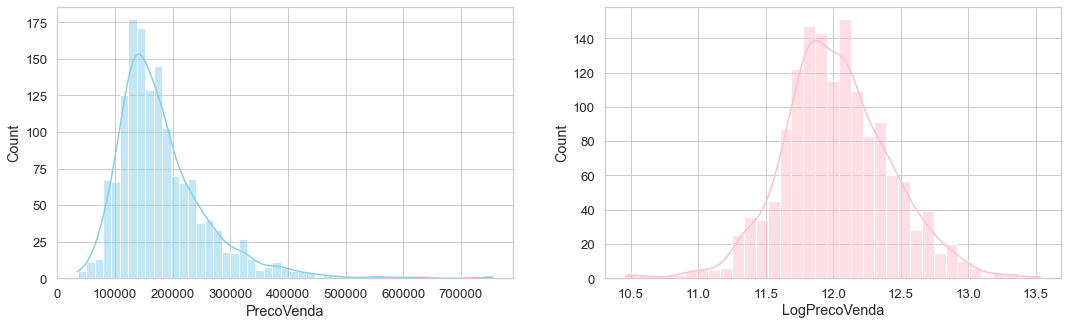

In [17]:
# Verificando distribuição da variável de interesse
fig, axs = plt.subplots(1, 2, figsize=(18, 5), squeeze=False)

sns.histplot(data=df, x="PrecoVenda", kde=True, color="skyblue", ax=axs[0, 0])

# Criando nova variável com o log de PrecoVenda
df['LogPrecoVenda'] = np.log(df['PrecoVenda'].values)
sns.histplot(data=df, x="LogPrecoVenda", kde=True, color="pink", ax=axs[0, 1])

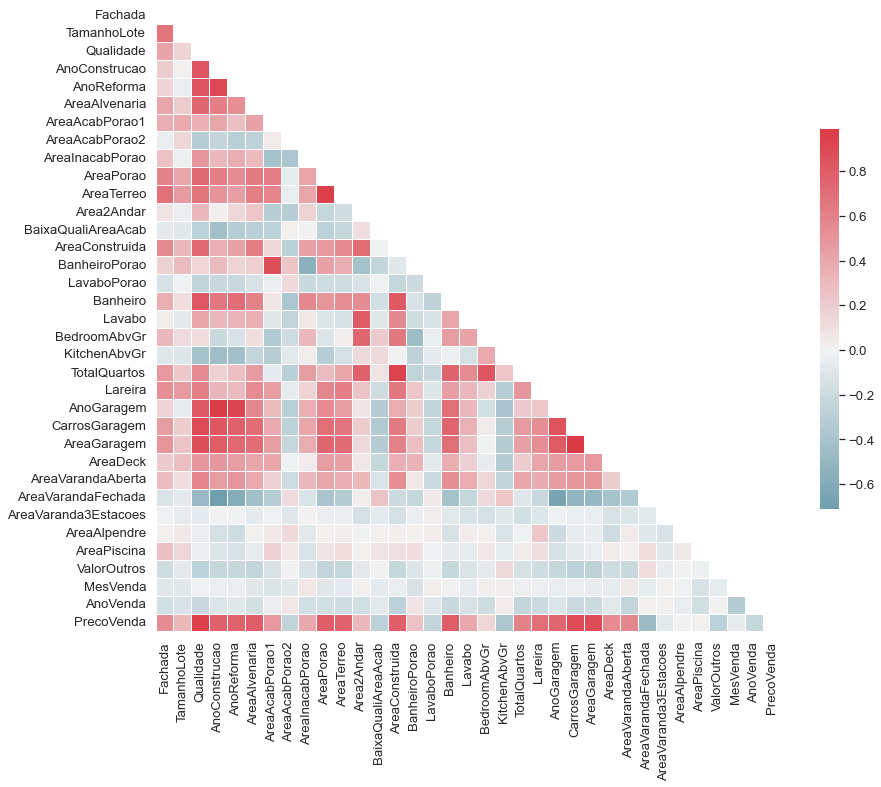

In [18]:
corr_matrix = df[vars_num + [target]].corr()
plot_corr_matrix(corr_matrix)

In [19]:
#Correlação das variáveis númericas com a variável de interesse (PrecoVenda)
corr_matrix[target].sort_values(ascending=False)

PrecoVenda              1.000000
Qualidade               0.790982
AreaConstruida          0.708624
CarrosGaragem           0.640409
AreaGaragem             0.623431
AreaPorao               0.613581
AreaTerreo              0.605852
Banheiro                0.560664
TotalQuartos            0.533723
AnoConstrucao           0.522897
AnoReforma              0.507101
AnoGaragem              0.486362
AreaAlvenaria           0.477493
Lareira                 0.466929
AreaAcabPorao1          0.386420
Fachada                 0.351799
AreaDeck                0.324413
Area2Andar              0.319334
AreaVarandaAberta       0.315856
Lavabo                  0.284108
TamanhoLote             0.263843
BanheiroPorao           0.227122
AreaInacabPorao         0.214479
BedroomAbvGr            0.168213
AreaAlpendre            0.111447
AreaPiscina             0.092404
MesVenda                0.046432
AreaVaranda3Estacoes    0.044584
AreaAcabPorao2         -0.011378
LavaboPorao            -0.016844
ValorOutro

<AxesSubplot:xlabel='PrecoVenda', ylabel='AreaGaragem'>

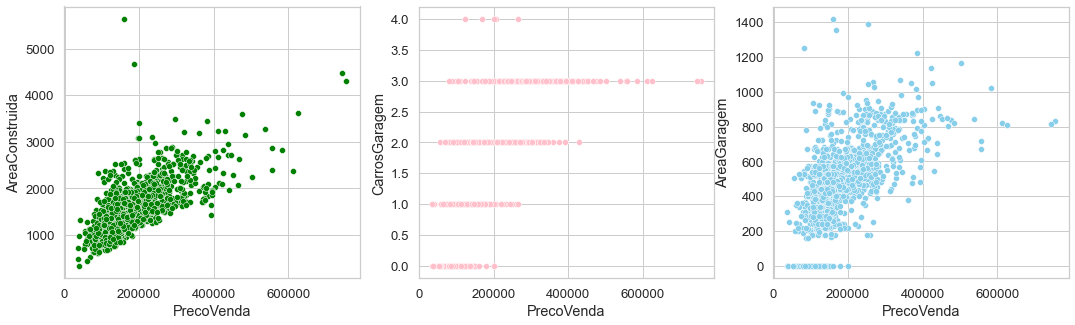

In [20]:
# Verificando graficamente o relacionamento entre as variáveis com maiores correlações
# Gráfico de Dispersão
fig, axs = plt.subplots(1, 3, figsize=(18, 5), squeeze=False)

sns.scatterplot(data=df, x="PrecoVenda", y="AreaConstruida", color="green", ax=axs[0, 0])
sns.scatterplot(data=df, x="PrecoVenda", y="CarrosGaragem", color="pink", ax=axs[0, 1])
sns.scatterplot(data=df, x="PrecoVenda", y="AreaGaragem", color="skyblue", ax=axs[0, 2])


<AxesSubplot:xlabel='PrecoVenda', ylabel='AreaTerreo'>

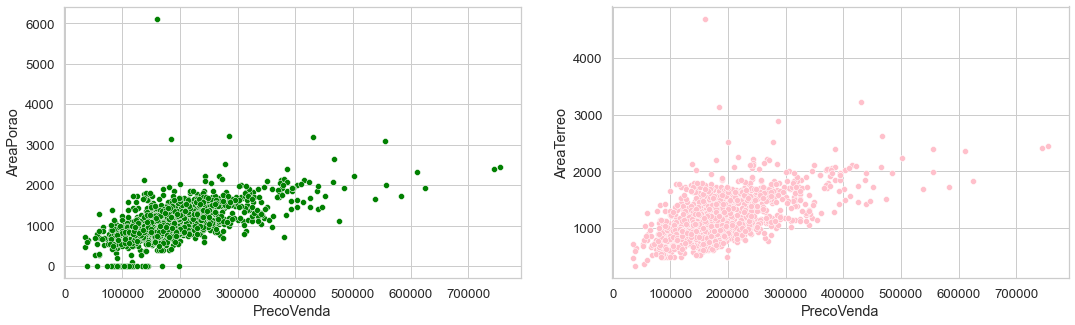

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5), squeeze=False)

sns.scatterplot(data=df, x="PrecoVenda", y="AreaPorao", color="green", ax=axs[0, 0])
sns.scatterplot(data=df, x="PrecoVenda", y="AreaTerreo", color="pink", ax=axs[0, 1])

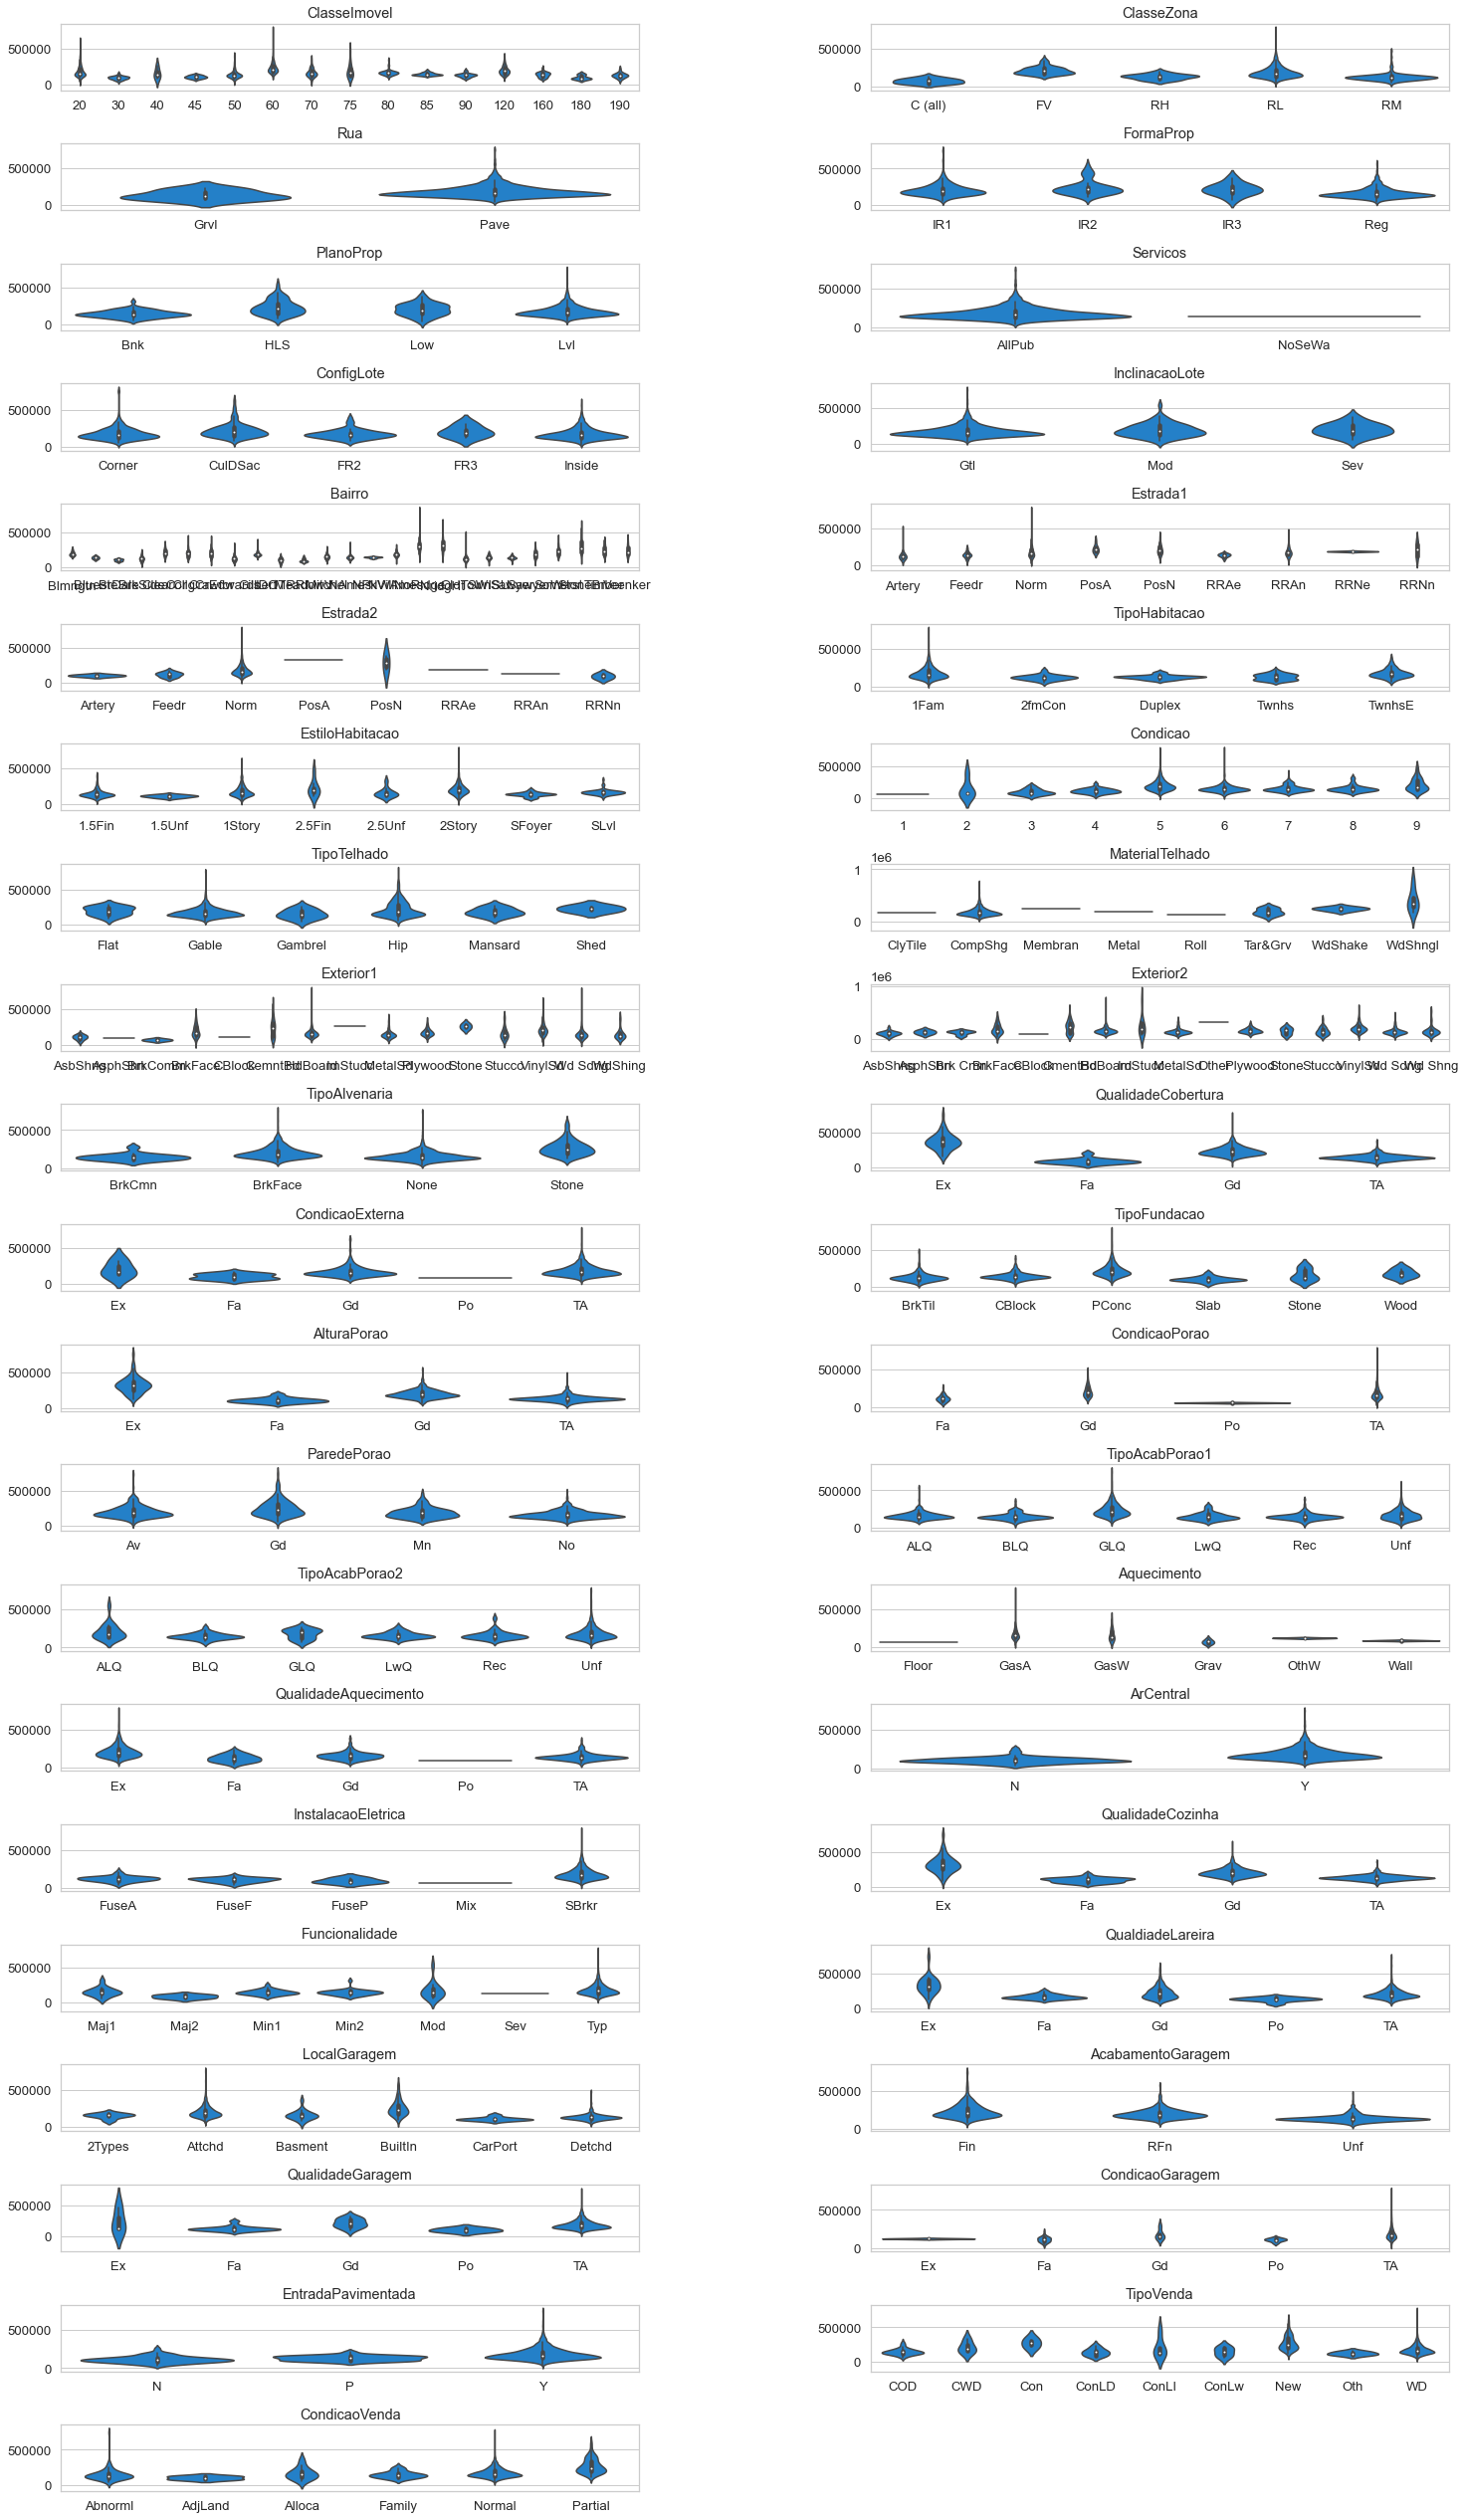

In [22]:
# Configurando a figura do matplot lib
fig = plt.figure(figsize=(25,90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

total_plots = len(vars_cat)
i = 0
# Iterando para todas variaveis categoricas
for var in vars_cat:
    # Pegando o index certo para plotar o grafico
    ax = fig.add_subplot(total_plots, 2, i+1)
    # Desenhando o grafico do tipo violinplot
    sns.violinplot(x=var, y=target, color='#0984e3', title=var,data=df, ax=ax)
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

plt.show()

In [23]:
#Verificando a cardinalidade das variáveis categóricas
print('Cardinalidade médias das categóricas:', np.mean(df[vars_cat].nunique()))
df[vars_cat].nunique().sort_values(ascending=False)

Cardinalidade médias das categóricas: 6.414634146341464


Bairro                  25
Exterior2               16
ClasseImovel            15
Exterior1               15
TipoVenda                9
Estrada1                 9
Condicao                 9
Estrada2                 8
EstiloHabitacao          8
MaterialTelhado          8
Funcionalidade           7
LocalGaragem             6
Aquecimento              6
TipoAcabPorao2           6
TipoAcabPorao1           6
TipoFundacao             6
CondicaoVenda            6
TipoTelhado              6
ConfigLote               5
CondicaoGaragem          5
QualidadeGaragem         5
QualdiadeLareira         5
InstalacaoEletrica       5
QualidadeAquecimento     5
CondicaoExterna          5
TipoHabitacao            5
ClasseZona               5
ParedePorao              4
CondicaoPorao            4
TipoAlvenaria            4
AlturaPorao              4
QualidadeCozinha         4
PlanoProp                4
FormaProp                4
QualidadeCobertura       4
InclinacaoLote           3
AcabamentoGaragem        3
E

In [24]:
#Criando novas features (feature engineering)
# Selecionando apenas as features de area
area_features = [var for var in vars_num if 'area' in var.lower()]

# Eleveando ao quadrado as features de area
df_area_squared = df[area_features].pow(2)
df_area_squared.columns = [var + '_squared' for var in area_features]
df_processed = pd.concat([df, df_area_squared], axis=1)
print('\nNew area squared features: ', list(df_area_squared.columns))

# Dividino o total de alguns itens pela area construida
itens = ['Banheiro', 'Lavabo', 'TotalQuartos', 'Lareira', 'CarrosGaragem']
df_itens_over_area = df_processed[itens].div(df_processed.AreaConstruida, axis=0)
df_itens_over_area.columns = [var + '_sobreArea' for var in itens]
df_processed = pd.concat([df_processed, df_itens_over_area], axis=1)
print('\nNew itens over area features: ', list(df_itens_over_area.columns))

# Shape do novo dataset processado
print('Shape old df: ', df.shape)
print('Shape new df: ', df_processed.shape)


New area squared features:  ['AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared']

New itens over area features:  ['Banheiro_sobreArea', 'Lavabo_sobreArea', 'TotalQuartos_sobreArea', 'Lareira_sobreArea', 'CarrosGaragem_sobreArea']
Shape old df:  (1460, 77)
Shape new df:  (1460, 98)


In [25]:
# Features numéricas
num_features = df_processed.select_dtypes(include=['int', 'float']).columns.tolist()
num_features.remove('LogPrecoVenda')
num_features.remove('PrecoVenda')
print(f'\nnumerical features({len(num_features)}): {num_features}')

# Features categóricas
cat_features = df_processed.select_dtypes(exclude=['int', 'float']).columns.tolist()
df_processed[cat_features] = df_processed[cat_features].astype("category")
print(f'\ncategorical features({len(cat_features)}): {cat_features}')


numerical features(55): ['Fachada', 'TamanhoLote', 'Qualidade', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda', 'AreaAlvenaria_squared', 'AreaAcabPorao1_squared', 'AreaAcabPorao2_squared', 'AreaInacabPorao_squared', 'AreaPorao_squared', 'AreaTerreo_squared', 'Area2Andar_squared', 'BaixaQualiAreaAcab_squared', 'AreaConstruida_squared', 'AreaGaragem_squared', 'AreaDeck_squared', 'AreaVarandaAberta_squared', 'AreaVarandaFechada_squared', 'AreaVaranda3Estacoes_squared', 'AreaAlpendre_squared', 'AreaPiscina_squared', 'Banheiro_sobreArea', 'Lavabo_sobreAr

### 1. Objetivo I - Regressão Linear para interpretabilidade

In [26]:
#Utilizando apenas exemplos onde a variável Condicao é igual à Normal
df_rl = df_processed[df_processed.CondicaoVenda == 'Normal']

In [27]:
df_rl = pd.get_dummies(df_rl, columns=['ArCentral'], drop_first=True)

In [28]:
# Valores da var QualidadeCozinha:
# Ex Excelente
# Gd Bom
# TA Médio / Comum
# Fa Razoável
# Po Ruim
df_rl['QualidadeCozinha'] = df_rl['QualidadeCozinha'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
len(df_rl)

1198

- Selecione 6 features para o seu modelo;
- Constraints do modelo: essa regressão linear deve ter um R² mínimo de 0.85 e conter exatamente 6 features/variáveis. Todas as features devem ter um P-value maior do que 0.95 e não podem ser colineares. Não é necessário separar esse dataset em treino e teste, já que o foco nessa etapa é na interpretação dos coeficientes de uma regressão linear.

In [29]:
#Usando o VIF (Variance Inflation Factor) para verificar a colinearidade de certos conjutos de variáveis
#Tentando achar o melhor conjunto de variáveis com maior R2 e menor VIF

#vars_rl = ["AreaConstruida_squared", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro_sobreArea", "ArCentral_Y"] # R2 0.694 / VIF 60.73
#plot_vif(calc_vif(df_rl[vars_rl])) VIF 85.79

vars_rl = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"] 
plot_vif(calc_vif(df_rl[vars_rl]))

vars:  ['variables', 'VIF']
Variable Inflation Factors: 108.14489255540519 



In [30]:
#vars_rl = ["AreaConstruida_squared", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro_sobreArea", "ArCentral_Y"] # R2 0.84
#formula ="LogPrecoVenda ~ " + ' + '.join(vars_rl)
#print('formula: ', formula)

vars_rl = ["AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y"]
formula ="LogPrecoVenda ~ " + ' + '.join(vars_rl)
print('formula: ', formula)

# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df_rl).fit()

# Plotando o sumário do modelo
print(model.summary())

formula:  LogPrecoVenda ~ AreaConstruida + Qualidade + CarrosGaragem + AreaPorao + Banheiro + ArCentral_Y
                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1139.
Date:                Fri, 24 Jun 2022   Prob (F-statistic):               0.00
Time:                        10:27:20   Log-Likelihood:                 644.77
No. Observations:                1198   AIC:                            -1276.
Df Residuals:                    1191   BIC:                            -1240.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [31]:
#Verificando o VIF das variáveis escolhidas para compor a regressão linear
vif = calc_vif(df_rl[vars_rl])
print('vars: ', vars_rl)
print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
vif

vars:  ['AreaConstruida', 'Qualidade', 'CarrosGaragem', 'AreaPorao', 'Banheiro', 'ArCentral_Y']
Variable Inflation Factors: 108.14489255540519 



,variables,VIF
0,AreaConstruida,20.561712
1,Qualidade,36.544938
2,CarrosGaragem,11.040106
3,AreaPorao,10.491630
4,Banheiro,17.210607
5,ArCentral_Y,12.295900


,AreaConstruida,Qualidade,CarrosGaragem,AreaPorao,Banheiro,ArCentral_Y
AreaConstruida,1.000000,0.576861,0.465061,0.383522,0.650396,0.076536
Qualidade,0.576861,1.000000,0.564465,0.494476,0.525825,0.255123
CarrosGaragem,0.465061,0.564465,1.000000,0.409797,0.452606,0.211898
AreaPorao,0.383522,0.494476,0.409797,1.000000,0.304859,0.202598
Banheiro,0.650396,0.525825,0.452606,0.304859,1.000000,0.074507
ArCentral_Y,0.076536,0.255123,0.211898,0.202598,0.074507,1.000000


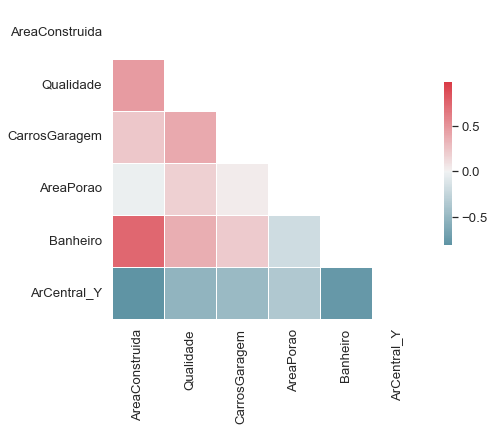

In [32]:
#Correlação das variáveis da regressão linear
corr_matrix = df_rl[vars_rl].corr()
plot_corr_matrix(df_rl[vars_rl].corr(), (7, 6))
corr_matrix

<AxesSubplot:xlabel='AreaConstruida'>

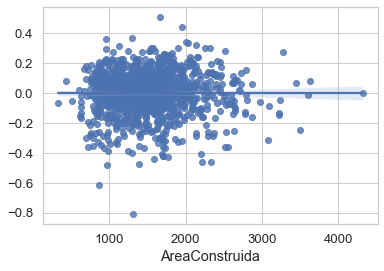

In [33]:
#Checando a Heterocedasticidade (aumento do erro conforme aumenta a área do imóvel)
sns.regplot(x=df_rl.AreaConstruida , y=model.resid)

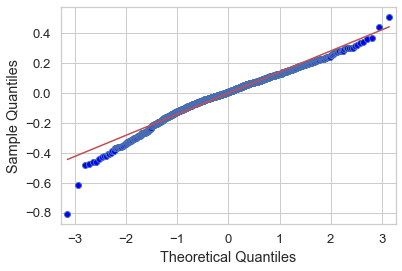

In [34]:
sm.qqplot(model.resid, line="s");

In [35]:
#Y ~ 0.02X1 + b2X2 + b3X3
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.02
Qualidade         10.58
CarrosGaragem      9.41
AreaPorao          0.02
Banheiro           1.56
ArCentral_Y       24.58
dtype: float64

Interpretação dos coeficientes:

- AreaConstruida 0.02% (Aumento de 1 unidade da AreaConstruida aumenta em 0.02% o preço do imóvel)
- Qualidade 10.58% (Para cada aumento do nível de qualidade, indo de 1-muito ruim até 10-Muito excelente, aumenta em 10.58% o preço do imóvel)
- CarrosGaragem 9.41% (Aumento de 1 unidade de CarrosGaragem aumenta em 9.41% o preço do imóvel)
- AreaPorao 0.02% (Aumento de 1 unidade da AreaPorao aumenta em 0.02% o preço do imóvel)
- Banheiro 1.56% (Aumento de 1 unidade de Banheiros aumenta em 1.56% o preço do imóvel)
- ArCentral_Y 24.58% (Presença de ar condicionado central aumenta 24.58% o valor do imóvel)

### 2. Objetivo II: poder preditivo, regressão via random forest

In [36]:
#Splitando os dados em treino e teste
features = vars_num + vars_cat

(
  X_train, X_test, 
  X_val, y_train, 
  y_test, y_val
) = train_test_valid_split(df_processed, features=features, target=target, test_size=0.3, valid_size=0.5, random_state=42)

print('X Train shape', X_train.shape)
print('X Val shape', X_val.shape)
print('X Test shape', X_test.shape)

X Train shape (1022, 75)
X Val shape (219, 75)
X Test shape (219, 75)


In [37]:
#Pre-processamento dos datasets de treino, teste e validação
def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[vars_cat] = cat_imputer.fit_transform(X_train[vars_cat])
  X_val[vars_cat] = cat_imputer.transform(X_val[vars_cat])
  X_test[vars_cat] = cat_imputer.transform(X_test[vars_cat])

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[vars_cat] = cat_imputer.fit_transform(X_train[vars_cat])
  X_val[vars_cat] = cat_imputer.transform(X_val[vars_cat])
  X_test[vars_cat] = cat_imputer.transform(X_test[vars_cat])

  # Categoricals pre-processing (categorical encoders)
  target_encoder = TargetEncoder()
  X_train[vars_cat] = target_encoder.fit_transform(X_train[vars_cat], y_train)
  X_val[vars_cat] = target_encoder.transform(X_val[vars_cat])
  X_test[vars_cat] = target_encoder.transform(X_test[vars_cat])

  # Numerical pre-processing (missing imputer)
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[vars_num] = num_imputer.fit_transform(X_train[vars_num])
  X_val[vars_num] = num_imputer.transform(X_val[vars_num])
  X_test[vars_num] = num_imputer.transform(X_test[vars_num])

  return X_train, X_val, X_test

X_train, X_val, X_test = random_forest_preprocessing(X_train.copy(), X_val.copy(), X_test.copy(), y_train)

Fitando um RandomForest baseline


In [38]:
from sklearn.ensemble import RandomForestRegressor
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validation')
baseline_report

,metric,validation
0,RMSE,28305.63
1,MAE,16625.31
2,R^2,0.89
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,171544.09


Achando os melhores hiperparâmetros para o RandomForest

In [39]:
# hiperparams: n_estimators: [], max_features: [], min_samples_leaf: []
for n_estimators in [10, 30, 50, 70, 100, 150, 200]:
  print(f'Random forest, with n_estimators {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with n_estimators 10
rmse: 28091.171897074793

Random forest, with n_estimators 30
rmse: 28311.32092617905

Random forest, with n_estimators 50
rmse: 28740.32802726355

Random forest, with n_estimators 70
rmse: 28474.7620001423

Random forest, with n_estimators 100
rmse: 28305.63433264868

Random forest, with n_estimators 150
rmse: 28270.694098337695

Random forest, with n_estimators 200
rmse: 28618.71807103648



In [40]:
# hiperparams: n_estimators: [150], max_features: [], min_samples_leaf: []
for max_features in ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.6]:
  print(f'Random forest, with max_features {max_features}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=max_features, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with max_features sqrt
rmse: 30669.622398887972

Random forest, with max_features 0.1
rmse: 30591.37595728279

Random forest, with max_features 0.2
rmse: 28307.15976818109

Random forest, with max_features 0.3
rmse: 28611.565335361007

Random forest, with max_features 0.4
rmse: 28004.387756350407

Random forest, with max_features 0.6
rmse: 27889.414317288025



In [41]:
# hiperparams: n_estimators: [150], max_features: [0.3], min_samples_leaf: []
for min_samples_leaf in list(range(1,6)):
  print(f'Random forest, with min_samples_leaf {min_samples_leaf}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= min_samples_leaf, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with min_samples_leaf 1
rmse: 28611.565335361007

Random forest, with min_samples_leaf 2
rmse: 29017.753343967845

Random forest, with min_samples_leaf 3
rmse: 30342.033620139217

Random forest, with min_samples_leaf 4
rmse: 30829.5806026963

Random forest, with min_samples_leaf 5
rmse: 32506.587791149046



Random Forest com os melhores hiperparâmetros

In [42]:
# hiperparams: n_estimators: [150], max_features: [0.3], min_samples_leaf: [1]
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred = rf_model.predict(X_val)
metrics_report(y_val, y_val_pred, 'validation')

,metric,validation
0,RMSE,28611.57
1,MAE,16196.17
2,R^2,0.89
3,MAPE,0.09
4,Avg. target,174313.75
5,Avg. Prediction,172145.31


In [43]:
# Importância das features, removendo variáveis pouco importantes
print('Running permutation feature importance')
permutation_result = permutation_importance(rf_model, X_val, y_val, n_repeats=5, random_state=42)

Running permutation feature importance


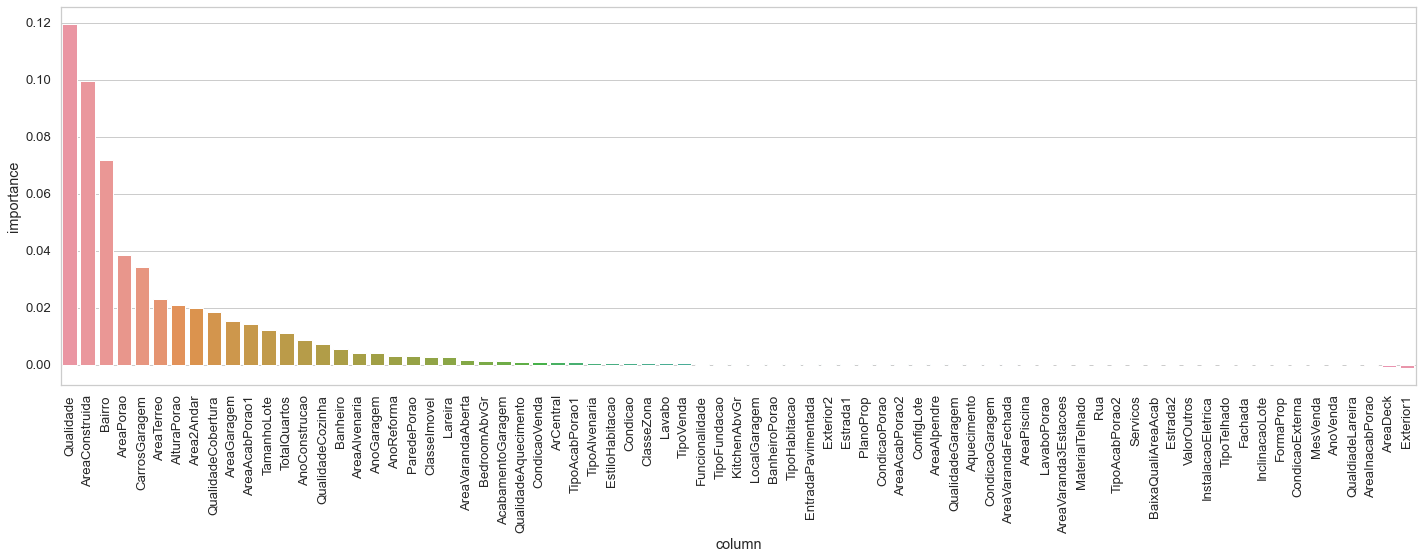

In [44]:
# plotando o permutation feature importance
importances = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [45]:
# Obtendo os 40 melhores features
best_features = importances.head(25).column.tolist()
print(best_features)

['Qualidade', 'AreaConstruida', 'Bairro', 'AreaPorao', 'CarrosGaragem', 'AreaTerreo', 'AlturaPorao', 'Area2Andar', 'QualidadeCobertura', 'AreaGaragem', 'AreaAcabPorao1', 'TamanhoLote', 'TotalQuartos', 'AnoConstrucao', 'QualidadeCozinha', 'Banheiro', 'AreaAlvenaria', 'AnoGaragem', 'AnoReforma', 'ParedePorao', 'ClasseImovel', 'Lareira', 'AreaVarandaAberta', 'BedroomAbvGr', 'AcabamentoGaragem']


Retreinando o RandomForest apenas com as top 25 variáveis mais importantes

In [46]:
# Ajustando o modelo final da RandomForest
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Previsões de computação
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_val[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Calculando as métricas de desempenho do modelo de treinamento, validação e teste
train_report = metrics_report(y_train, y_train_pred, 'train')
val_report = metrics_report(y_val, y_val_pred, 'validation')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report, val_report[['validation']],  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(features)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 75)
            metric  validation
0             RMSE    28305.63
1              MAE    16625.31
2              R^2        0.89
3             MAPE        0.09
4      Avg. target   174313.75
5  Avg. Prediction   171544.09

Final report (total features: 25)
            metric      train  validation       test
0             RMSE   11213.03    26389.94   22501.32
1              MAE    6336.34    15858.21   15034.95
2              R^2       0.98        0.91       0.92
3             MAPE       0.04        0.09       0.10
4      Avg. target  181312.69   174313.75  185701.65
5  Avg. Prediction  181008.55   172179.83  185960.21


Running permutation feature importance with the final model on the held-out testing set


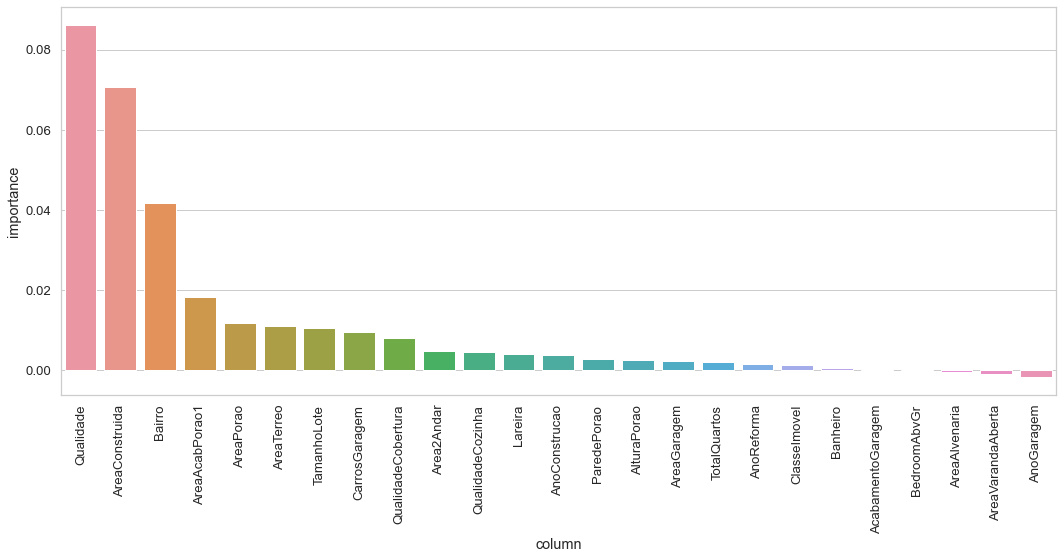

In [47]:
# Computando a importância das features do modelo final no dataset de test (held-out testing set)
print('Running permutation feature importance with the final model on the held-out testing set')
permutation_result = permutation_importance(rf_model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()